In [18]:
# Imports
import numpy as np
import pandas as pd
from typing import List
from collections import OrderedDict

import torch
from torch.jit import RecursiveScriptModule


# other libraries
from typing import Final

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.getcwd())


c:\Users\anton\OneDrive\Escritorio\TERCERO\NLP\ProyectoFinal\rnn_explainability


In [19]:

# own modules
from src.model_utils import load_model
from src.model_utils import predict_single_text
from src.model_utils import predict_multiple_text
from src.model_utils import load_w2v_model
from src.model_utils import set_seed
from src.RNNModelTrain.data import tokenize_tweet
# permutation importance
from sklearn.inspection import permutation_importance

In [20]:
"""
# permutation importance
from sklearn.inspection import permutation_importance"""

'\n# permutation importance\nfrom sklearn.inspection import permutation_importance'

In [21]:
# static variables
DATA_PATH: Final[str] = "NLP_Data/data"
MODEL_TYPE: Final[str] = "IMDB"  # "TweepFake"

# set device
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
set_seed(42)

In [22]:
import os 
print(os.getcwd())


c:\Users\anton\OneDrive\Escritorio\TERCERO\NLP\ProyectoFinal\rnn_explainability


In [23]:

# load the model
if MODEL_TYPE == "IMDB":
    model: RecursiveScriptModule = load_model("IMDB_best_model")
else:
    model: RecursiveScriptModule = load_model("best_model")
    
# Load the w2v model
w2vec_model = load_w2v_model()

In [24]:
if MODEL_TYPE == "IMDB":
    file_path = DATA_PATH + '/test.txt'
    data: pd.DataFrame = pd.read_csv(file_path, sep='\t', header=None)
    data.columns = ['text', 'tag']

else:
    file_path = DATA_PATH + '/test.csv'
    data: pd.DataFrame = pd.read_csv(file_path)

    # replace the target column with a binary representation
    data['tag'] = data['account.type'].replace('human', 0)
    data['tag'] = data['tag'].replace('bot', 1)
    # Only keep columns text and tag
    data = data[['text', 'tag']]

print(data.head())

                                                text  tag
0  I first saw The Buddy Holly Story when I was a...    1
1  There were so many things wrong with this movi...    0
2  There's a unique place in the pantheon of John...    1
3  It kicks you in the stomach. There are other f...    1
4  To start, I'm not a person to rate movies that...    0


In [25]:
# Test the model with a single text
text = data['text'][2]
print(text)
predicted = predict_single_text(text, model, device)
print(f"Predicted: {predicted}, Real: {data['tag'][0]}")

There's a unique place in the pantheon of John Ford films for Wagonmaster, Sergeant Rutledge, and The Sun Shines Bright. It was these three films with no box office names in them that Ford didn't have to tailor the film around the persona of a star being it John Wayne, Henry Fonda, or any of the others he worked with. Not surprising that Ford considered all these as favorites of one kind or another. <br /><br />Ben Johnson and Harry Carey, Jr. a couple of likable cowpokes sign on to guide a Mormon wagon train to a valley in Arizona territory. Along the way they are joined first by a group stranded players from a medicine show and then by a family of outlaws on the run named Clegg. Their stories merge and what happens is the basis of the film's plot.<br /><br />Had Wagonmaster been done even 10 years earlier on the strength of the two performances turned in by Johnson and Carey, both probably would have had substantial careers as B picture cowboys. In the case of Johnson it would have b

In [26]:
def classifier_fn(text: str) -> int:
    predictions = predict_multiple_text(text, model, device, probability=True)
    # We have 2 classes. build the array (d, k) where d is the prediction and k is the number of classes
    array = []
    for prediction in predictions:
        array.append(np.array([1 - prediction, prediction]))
    array = np.array(array)
    return array

In [29]:
import random
def permutation_importance(text):
    """
    This function calculates the permutation importance of the classifier_fn function.

    Args:
        text: text to calculate the permutation importance.

    Returns:
        The permutation importance of the classifier_fn function.
    """
    
    # tokenize the text
    tokenized_text = tokenize_tweet(text)
    
    # get the predictions of the classifier_fn
    predictions = classifier_fn(tokenized_text)
    print(tokenized_text)
    # get the real class
    real_class = data['tag'][0]

    # get the initial probability
    initial_probability = predictions[0][real_class]

    # get the number of permutations
    n_permutations = 100

    # get the permutation importance
    permutation_importance = 0
    for _ in range(n_permutations):
        # shuffle the text
        shuffled_text = tokenized_text.copy()
        random.shuffle(shuffled_text)

        # get the predictions of the shuffled text
        shuffled_predictions = classifier_fn(shuffled_text)

        # get the shuffled probability
        shuffled_probability = shuffled_predictions[0][real_class]

        # update the permutation importance
        permutation_importance += shuffled_probability

    # calculate the permutation importance
    permutation_importance /= n_permutations
    permutation_importance -= initial_probability

    return permutation_importance

In [30]:

class_names = [0, 1]
print(f"Explaining result for: {text}")
result = permutation_importance(text)
print(result)


Explaining result for: There's a unique place in the pantheon of John Ford films for Wagonmaster, Sergeant Rutledge, and The Sun Shines Bright. It was these three films with no box office names in them that Ford didn't have to tailor the film around the persona of a star being it John Wayne, Henry Fonda, or any of the others he worked with. Not surprising that Ford considered all these as favorites of one kind or another. <br /><br />Ben Johnson and Harry Carey, Jr. a couple of likable cowpokes sign on to guide a Mormon wagon train to a valley in Arizona territory. Along the way they are joined first by a group stranded players from a medicine show and then by a family of outlaws on the run named Clegg. Their stories merge and what happens is the basis of the film's plot.<br /><br />Had Wagonmaster been done even 10 years earlier on the strength of the two performances turned in by Johnson and Carey, both probably would have had substantial careers as B picture cowboys. In the case of 

In [32]:
def classifier_fn_likelihood(text: str) -> int:
    # probability=False to get the likelihood instead of the probability
    predictions = predict_multiple_text(text, model, device, probability=False, likelihood=True)
    # We have 2 classes. build the array (d, k) where d is the prediction and k is the number of classes
    array = []
    for prediction in predictions:
        array.append(np.array([1 - prediction, prediction]))
    array = np.array(array)
    return array

In [41]:
from tqdm import tqdm
import re
text = "I love this movie, it is the best movie I have ever seen. The actors are amazing and the story is great."
def tokenize_tweet(tweet: str) -> List[str]:
    """
    Tokenizes a given tweet by splitting the text into words, and doing any cleaning, replacing or normalization deemed useful

    Args:
        tweet (str): The tweet text to be tokenized.

    Returns:
        List[str]: A list of strings, representing the tokenized components of the tweet.
    """
    USR_MENTION_TOKEN = "<!USR_MENTION>"
    URL_TOKEN = "<!URL>"
    tweet = re.sub(r'@\w+', USR_MENTION_TOKEN, tweet)

    # replace the urls with a specific token
    tweet = re.sub(r'http\S+', URL_TOKEN, tweet)

    # remove the hashtags from the tweet
    tweet = re.sub(r'#\w+', '', tweet)

    return tweet.split()

def likelihood_permutation_importance(text):
    """
    This function calculates the likelihood permutation importance of each word in the text.

    Args:
        text: Text to calculate the likelihood permutation importance.

    Returns:
        A dictionary with the likelihood permutation importance of each word in the text.
    """
    
    # Tokenize the text
    tokens = tokenize_tweet(text)

    # Get the predictions of the classifier_fn
    predictions = classifier_fn(text)

    # Get the real class
    real_class = data['tag'][0]

    # Get the initial probability
    initial_probability = predictions[0][real_class]

    # Initialize permutation importance dictionary
    permutation_importance = {}

    # Iterate over each token (word) in the text
    for i, token in enumerate(tqdm(tokens, desc="Calculating permutation importance")):
        # Initialize importance for current token
        token_importance = 0

        # Iterate over each possible position for the current token
        for j in range(len(tokens)):
            if j != i:
                # Create a copy of tokens with the current token moved to position j
                shuffled_tokens = list(tokens)
                shuffled_tokens.pop(i)
                shuffled_tokens.insert(j, token)

                # Join the shuffled tokens back into a text
                shuffled_text = ' '.join(shuffled_tokens)

                # Get the predictions of the shuffled text
                shuffled_predictions = classifier_fn_likelihood(shuffled_text)

                # Get the shuffled probability
                shuffled_probability = shuffled_predictions[0][real_class]

                # Accumulate the importance of moving the current token to position j
                token_importance += shuffled_probability - initial_probability

        # Store the total importance for the current token
        permutation_importance[token] = token_importance

    return permutation_importance



In [42]:
# Now we will test the new method with the same text as before.
print(f"Explaining result for: {text}")
result = likelihood_permutation_importance(text)
print(result)

Explaining result for: I love this movie, it is the best movie I have ever seen. The actors are amazing and the story is great.


Calculating permutation importance: 100%|██████████| 22/22 [00:11<00:00,  1.86it/s]

{'I': -9.03238369524479, 'love': -9.263490304350853, 'this': -9.232991367578506, 'movie,': -9.07205594331026, 'it': -9.153269538655877, 'is': -9.153269538655877, 'the': -9.232991367578506, 'best': -9.277381852269173, 'movie': -9.07205594331026, 'have': -9.221758469939232, 'ever': -8.969728231430054, 'seen.': -8.843939036130905, 'The': -9.218764141201973, 'actors': -9.125543236732483, 'are': -9.125543236732483, 'amazing': -9.125543236732483, 'and': -9.125543236732483, 'story': -8.843939036130905, 'great.': -9.297912329435349}


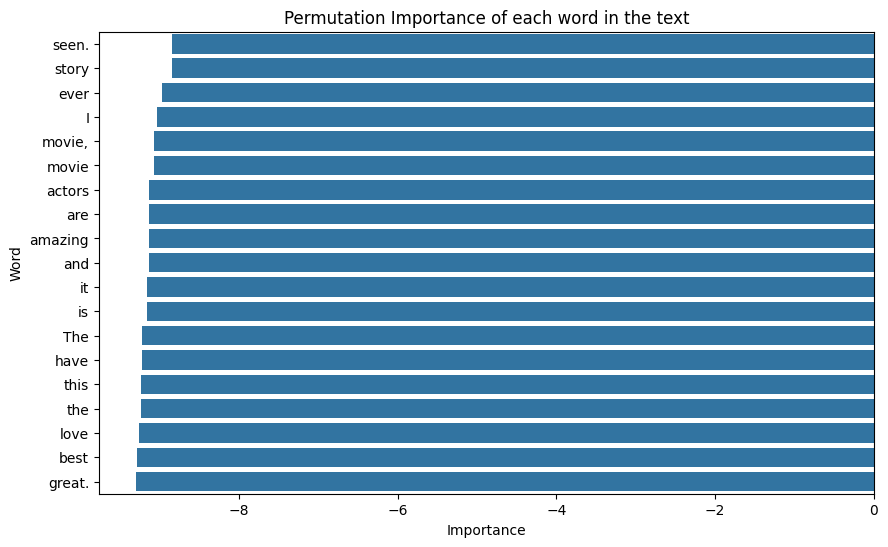

In [43]:
#Now lets plot the results
def plot_permutation_importance(perm_importance: dict, title: str):
    """
    Plots the permutation importance of each word in a text.

    Args:
        perm_importance: A dictionary with the permutation importance of each word in the text.
        title: The title of the plot.
    """
    # Sort the permutation importance by value
    perm_importance = OrderedDict(sorted(perm_importance.items(), key=lambda x: x[1], reverse=True))

    # Create a dataframe from the permutation importance
    df = pd.DataFrame(list(perm_importance.items()), columns=['Word', 'Importance'])

    # Plot the permutation importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Word', data=df)
    plt.title(title)
    plt.show()
    
plot_permutation_importance(result, "Permutation Importance of each word in the text")
